In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
#from sklearn.decomposition import PCA
from jupyterthemes import jtplot ; jtplot.style()
from glob import glob
from os import chdir 
path = '/Users/Alby/Desktop/NEUROMATCH/load'
chdir(path)

In [21]:
def processer(folders, truncate = None, return_stim = False) : 
    neural_df = pd.DataFrame(columns = ['spike_t', 'area', 'maus', 'stim_t'])
    for mouse, folder in enumerate(folders) : 
        spk = np.load(f'{folder}/spikes.times.npy', allow_pickle = True)
        spk = spk.reshape((spk.shape[0], ))
        if truncate != None : spk = spk[spk <= truncate]
            
        
        neurons = np.load(f'{folder}/spikes.clusters.npy', allow_pickle = True)
        neurons = neurons.reshape((neurons.shape[0], )) #array with neuron labels for each spike time
        if truncate != None : neurons = neurons[:spk.shape[0]] #cut to relevant subset

        loc = pd.read_csv(f'{folder}/channels.brainLocation.tsv', delim_whitespace = True)
        loc = loc['allen_ontology'].values #location of the ith channel

        channel = np.load(f'{folder}/clusters.peakChannel.npy', allow_pickle = True)
        channel = channel.reshape(channel.shape[0], ).astype('int') #channel of the ith cluster
        #IDs mapping cluster - > channel. this is a clusterx1 array with each entry containing the channel ID of the ith cluster 
        print(f'Mapping neurons from {folder} to channels ... ')
        cluster_channel = [channel[cluster] for cluster in neurons] #generate an array containing the channel for each neuron
        #yields a list the same size as neurons with entries corresponding to the channel of that cluster
        print('Mapping channels to brain areas ...')
        brain_area = [loc[i] for i in cluster_channel] 
        #pull brain area 
        neural_subj_df = pd.DataFrame({'spike_t' : spk, 'neuron' : neurons, 'maus' : mouse, 
                                       'area' : brain_area}, index = np.arange(spk.shape[0]))
        neural_subj_df['maus'] = mouse
        neural_df = neural_df.append(neural_subj_df, ignore_index = True)
        
    if return_stim == True : 
        all_subj_df = pd.DataFrame(columns = ['cl', 'cr', 'stimtime', 'reward', 'response_type',
                                                 'rt'])
        print('''Getting behavioral data ...''')
        for i, folder in enumerate(folders) : 
            '''Grab all stimulus vectors. For the time paramaeters, we can use truncate to slice out
            the relevant indices. The shapes of these truncated versions can then be used to reshape
            categorical variables like contrast and reward type.'''
            rew_time = np.load(f'{folder}/trials.feedback_times.npy', allow_pickle = True)
            rew_time = rew_time.reshape(rew_time.shape[0], )
            #print(rew_time.shape)
            rew_time = rew_time[rew_time < truncate]
            #print(rew_time.shape)
            rew_type = np.load(f'{folder}/trials.feedbackType.npy', allow_pickle = True)
            rew_type = rew_type.reshape(rew_type.shape[0], )
            rew_type = rew_type[:rew_time.shape[0]]
                
            response_t =  np.load(f'{folder}/trials.response_times.npy', allow_pickle = True)
            response_t = response_t.reshape(response_t.shape[0], )
            response_t = response_t[response_t < truncate]
            response_type = np.load(f'{folder}/trials.response_choice.npy', allow_pickle = True)
            response_type = response_type.reshape(response_type.shape[0], )
            response_type = response_type[:response_t.shape[0]]
            
            stim = np.load(f'{folder}/trials.visualStim_times.npy', allow_pickle = True)
            stim = stim[stim < truncate]
            if stim.shape[0] == response_t.shape[0] + 1 : stim = stim[:-1]
            cl = np.load(f'{folder}/trials.visualStim_contrastLeft.npy', allow_pickle = True)
            cl = cl.reshape(cl.shape[0], )
            cl = cl[:stim.shape[0]]
            cr = np.load(f'{folder}/trials.visualStim_contrastRight.npy', allow_pickle = True)
            cr = cr.reshape(cr.shape[0], )
            cr = cr[:stim.shape[0]]
            
            response_t = response_t - stim
            
            #print(response_t.shape, response_type.shape, rew_time.shape, rew_type.shape,
                 #cl.shape, cr.shape, stim.shape)
            subj_df = pd.DataFrame({'cl' : cl, 'cr' : cr, 'stimtime' : stim, 'reward' : rew_type,
                            'response_type' : response_type, 'rt' : response_t})
            subj_df['maus'] = i
            all_subj_df = all_subj_df.append(subj_df, ignore_index = True)
        print('''~~~ OOOoOOOOooOoOOOOOOOOOOoooOooOOOOOOo ~~~''')
        return neural_df, all_subj_df
            
    else: return neural_df
    
def stimulus(row) : 
    '''return 1 for left, 0 for right contrast. corresponds to split_by column '''
    if row.cl > row.cr : return 1
    elif row.cr > row.cl : return 0
    elif row.cr == row.cl : return 'DROPME'
    
def reaction_coding(row) : 
    '''response column'''
    if row.response_type == 0 : return 'DROPME'
    if row.response_type == -1 : return 0
    else : return 1
    
def MR_clean(dat) : 
    '''prepares data for hddm.'''
    dat = dat[dat.cl != dat.cr] # no equal contrast
    dat = dat[dat.response_type != 0] # no no-gos
    dat['feedback'] = dat.reward.apply(lambda x : 0 if x == -1 else x) #turn -1 to 0
    dat['split_by'] = dat.apply(stimulus, axis = 1)
    dat['response'] = dat.apply(reaction_coding, axis = 1 )
    dat['q_init'] = 0.7
    dat = dat.rename(columns = {'maus' : 'subj_idx'})
    dat = dat.loc[dat.split_by != 'DROPME']
    dat = dat.loc[: , ['rt', 'subj_idx', 'response', 'response_type',
                       'split_by', 'feedback', 'q_init']]
    return dat

In [9]:
folders = glob('*')
neurons, process = processer(folders, truncate = 2000, return_stim = True)
process.head()

Mapping neurons from Cori_2016-12-14 to channels ... 
Mapping channels to brain areas ...
Mapping neurons from Richards_2017-10-29 to channels ... 
Mapping channels to brain areas ...
Mapping neurons from Forssmann_2017-11-01 to channels ... 
Mapping channels to brain areas ...
Mapping neurons from Lederberg_2017-12-05 to channels ... 
Mapping channels to brain areas ...
Getting behavioral data ...
~~~ OOOoOOOOooOoOOOOOOOOOOoooOooOOOOOOo ~~~


,cl,cr,stimtime,reward,response_type,rt,maus
0,1.0,0.0,65.269408,1.0,1.0,1.150204,0.0
1,0.0,0.5,71.202703,1.0,-1.0,1.399503,0.0
2,1.0,0.5,76.052380,1.0,1.0,0.949291,0.0
3,0.0,0.0,81.235263,1.0,0.0,2.266802,0.0
4,0.5,1.0,86.800952,-1.0,1.0,0.816776,0.0


In [22]:
 clean = MR_clean(process)

In [23]:
clean[clean.response_type == 0]

,rt,subj_idx,response,response_type,split_by,feedback,q_init


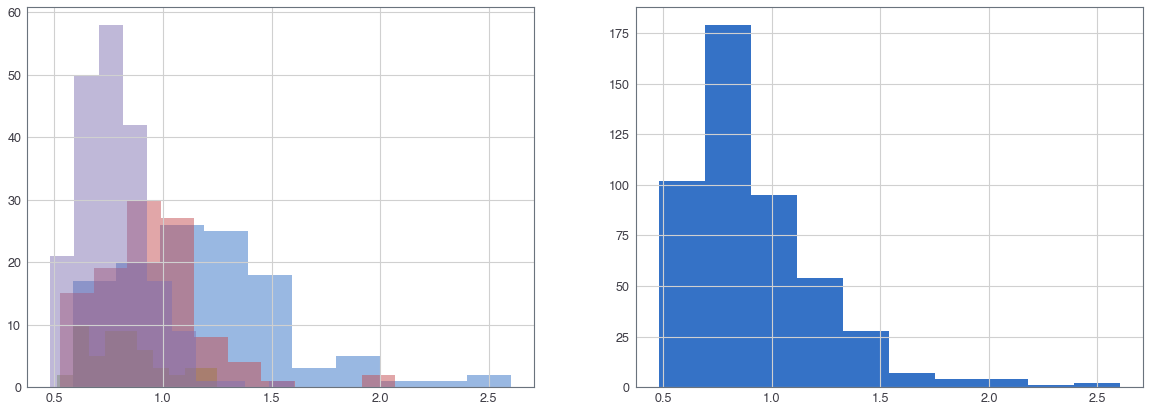

In [29]:
_, ax = plt.subplots(1, 2, figsize = (20, 7) )
for i, dat in clean.groupby('subj_idx').rt : 
    dat.hist(ax = ax[0], alpha = 0.5)
ax[1].hist(clean.rt)
plt.show()